# Using Y-factor method to calculate active component noise

In [1]:
from highz_exp.s_params import S_Params
import os
import glob
from os.path import join as pjoin

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob, copy, pickle
import skrf as rf
from scipy.signal import find_peaks
from scipy.ndimage import median_filter
from scipy.constants import Boltzmann as k_B
from highz_exp import fit_temperature, spec_class, plotter, unit_convert, fit_model, load_csv, spec_proc
from highz_exp.fit_temperature import Y_Factor_Thermometer
from highz_exp.s_params import S_Params
from highz_exp.spec_class import Spectrum

pjoin = os.path.join
pbase = os.path.basename

data_path = '/content/drive/Shareddrives/jbp Research/high-z (CMU)/Calibration/BenchMark_Data'
spec_base_path = '/content/drive/Shareddrives/jbp Research/high-z (CMU)/Calibration'
caltech_path = pjoin(spec_base_path, 'Caltech_Measurements')
plot_path = '/content/drive/Shareddrives/jbp Research/high-z (CMU)/Calibration/Plots'

In [ ]:
# define macros
# nchannels = 4
nfft = 32768
fs = 3276.8/4
fbins = np.arange(0, nfft//2)
df = fs/nfft
faxis = fbins*df
faxis_hz = faxis*1e6
freq_range = (0, 500) # MHz
y_41_5 = []
y_43 = []
for i in range(len(faxis)):
    y_41_5.append(-41.5)
    y_43.append(-43)

LEGEND = ['6" shorted', "8' cable open",'Black body','Ambient temperature load','Noise diode',"8' cable short",'6" open']

## For LNA + all second stage measurements at Caltech

In [ ]:
# parse and clean the files from Siglent SA
input_file = pjoin(caltech_path, 'Hot_Cold_Measurements', 'LNA_Second_Stage_Hot_Cold.csv')
load_csv.split_csv_by_trace_name(input_file, header_file=pjoin(caltech_path, 'Parsed_Cleaned', 'Meta_LNA_Second_Stage_Hot_Cold.csv'),
                                 data_file=pjoin(caltech_path, 'Parsed_Cleaned', 'Data_LNA_Second_Stage_Hot_Cold.csv'))

Split complete:
  Header file: /content/drive/Shareddrives/jbp Research/high-z (CMU)/Calibration/Caltech_Measurements/Parsed_Cleaned/Meta_LNA_Second_Stage_Hot_Cold.csv (30 rows)
  Data file: /content/drive/Shareddrives/jbp Research/high-z (CMU)/Calibration/Caltech_Measurements/Parsed_Cleaned/Data_LNA_Second_Stage_Hot_Cold.csv (3020 rows)


In [ ]:
# Read in the four traces for LNA + second-stage, and second-stage only
data_file = pjoin(caltech_path, 'Parsed_Cleaned', 'Data_LNA_Second_Stage_Hot_Cold.csv')
traces = load_csv.parse_trace_data(data_file)

Parsing trace: Trace A
Parsing trace: Trace B
Parsing trace: Trace C
Parsing trace: Trace D
Parsed 4 trace block(s)


In [ ]:
# plot the recorded spectra from hot-cold measurements
spectrum_A = Spectrum(traces['Trace A']['frequency'], traces['Trace A']['spectrum'], name='77K load - 2nd Stage')
spectrum_B = Spectrum(traces['Trace B']['frequency'], traces['Trace B']['spectrum'], name='300K load - 2nd Stage')
spectrum_C = Spectrum(traces['Trace C']['frequency'], traces['Trace C']['spectrum'], name='77K load - LNA+2nd Stage')
spectrum_D = Spectrum(traces['Trace D']['frequency'], traces['Trace D']['spectrum'], name='300K load - LNA+2nd Stage')
# spec_plot.plot_spectrum([spectrum_A, spectrum_B, spectrum_C, spectrum_D], save_dir=pjoin(caltech_path, 'Plots'), title='Hot-Cold Spectrum Recorded', suffix='Hot_Cold', ymin=-100, ymax=-75)

# convert these to mW
cold_second_stage = unit_convert.dbm_to_milliwatt(spectrum_A.spec)
hot_second_stage = unit_convert.dbm_to_milliwatt(spectrum_B.spec)
cold_lna = unit_convert.dbm_to_milliwatt(spectrum_C.spec)
hot_lna = unit_convert.dbm_to_milliwatt(spectrum_D.spec)

f = spectrum_A.f/1e6

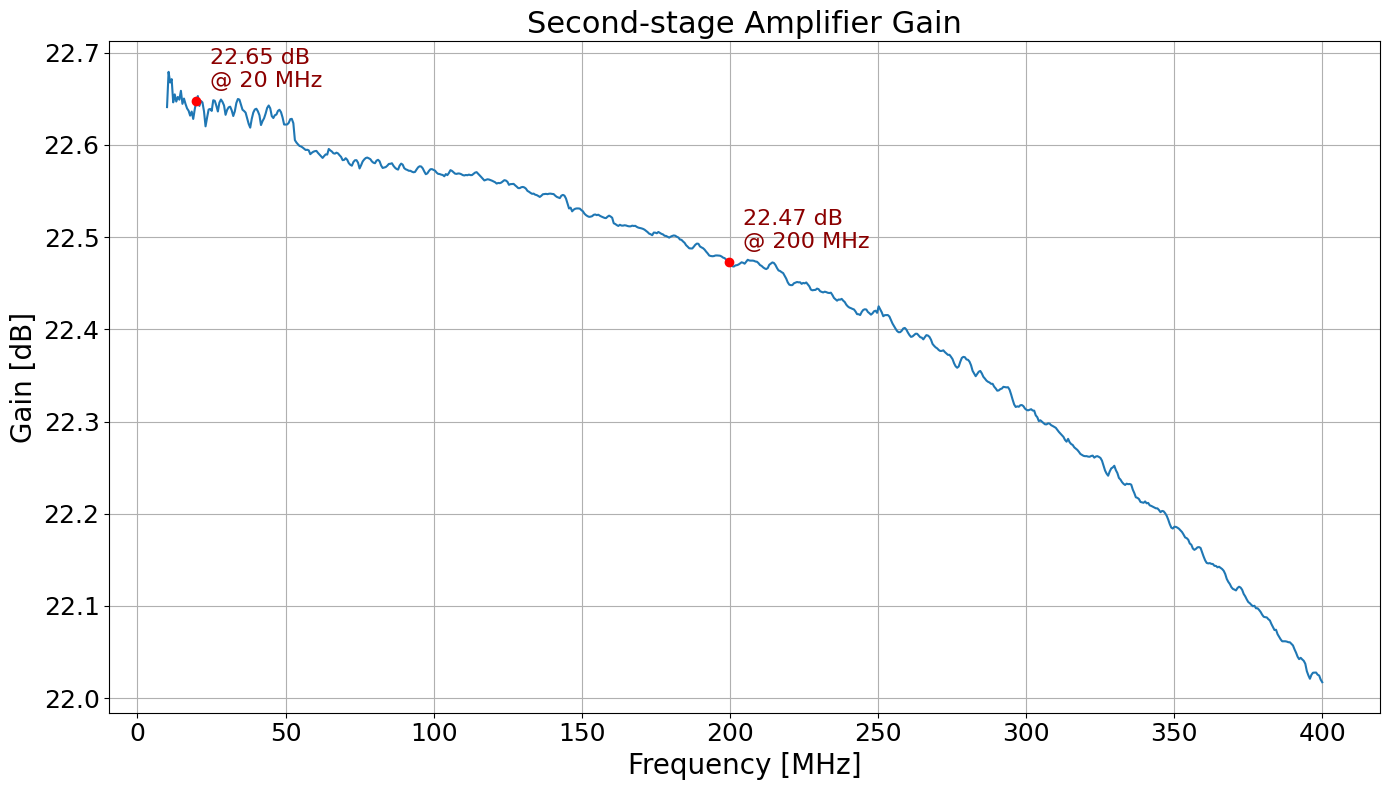

/usr/local/lib/python3.12/dist-packages/highz_exp/fit_temperature.py:76: RuntimeWarning: divide by zero encountered in divide
  T_sys = (T_hot - Y_factor * T_cold) / (Y_factor - 1)
/usr/local/lib/python3.12/dist-packages/highz_exp/fit_temperature.py:94: RuntimeWarning: divide by zero encountered in log10
  g_dut = 10 * np.log10((DUT_hot - DUT_cold) / ((T_hot - T_cold) * k_B * RBW))


In [ ]:
# plot the gain of the second stage amplifier


second_stage_ntwk = plotter.plot_load_s2p(second_stage, db=True, save_dir=pjoin(caltech_path, 'Plots'), title='Second-stage Amplifier Gain', suffix='WEA101')
wea_s21_db = unit_convert.sparam_to_dB(second_stage_ntwk.s[:, 1, 0])

# infer from hot-cold measurement
second_stage_thermo = Y_Factor_Thermometer(hot_second_stage, cold_second_stage, 'WEA101+SA_Gain', 300, 77, RBW=1e6)
# spec_plot.plot_gain(f, [second_stage_thermo.g, wea_s21_db], ['Hot-Cold Measurement', 'S21 Measurement'], start_freq=15, title='Measured WEA101 Gain (15-400 MHz)',
#                     save_path=pjoin(caltech_path, 'Plots', 'WEA101+SA_Gain_15.png'))

In [ ]:
# plot gain of LNA, WEA101
lna = pjoin(caltech_path, 'amp_s_params', 'LNA_5V.s2p')
second_stage = pjoin(caltech_path, 'amp_s_params', 'WEA101_5V.s2p')

s21s = S_Params([lna, second_stage], ['LNA', 'WEA101'])

In [ ]:
# Construct Thermometer to get all parameters
lna_thermo = Y_Factor_Thermometer(hot_lna, cold_lna, 'LNA', 300, 77, hot_second_stage, cold_second_stage)
# spec_plot.plot_gain(f, [lna_thermo.g, lna_s21_db], ['Hot-Cold Measurement', 'S21 Measurement'], start_freq=30, title='Measured LNA Gain (30-400 MHz)',
#                     save_path=pjoin(caltech_path, 'Plots', 'LNA_Gain_Zoomed_2.png'))

/usr/local/lib/python3.12/dist-packages/highz_exp/fit_temperature.py:109: RuntimeWarning: invalid value encountered in divide
  g_dut = 10 * np.log10((DUT_hot - DUT_cold) / (cal_hot - cal_cold))
/usr/local/lib/python3.12/dist-packages/highz_exp/fit_temperature.py:109: RuntimeWarning: divide by zero encountered in log10
  g_dut = 10 * np.log10((DUT_hot - DUT_cold) / (cal_hot - cal_cold))
/usr/local/lib/python3.12/dist-packages/highz_exp/fit_temperature.py:121: RuntimeWarning: divide by zero encountered in divide
  T_dut = T_sys - T_cal / (10**(g_dut / 10))
/usr/local/lib/python3.12/dist-packages/highz_exp/fit_temperature.py:121: RuntimeWarning: invalid value encountered in subtract
  T_dut = T_sys - T_cal / (10**(g_dut / 10))


In [ ]:
# lna_thermo.f = f
with open(pjoin(data_path, 'LNA_temperature_caltech.pkl'), 'wb') as f:
  pickle.dump(lna_thermo, f)

In [ ]:
# Plot LNA noise temperatures
lna_thermo.plot_temps(f, [lna_thermo.T_dut, lna_thermo.T_sys, lna_thermo.T_cal], labels=['LNA', 'LNA+WEA101+SA', 'WEA101+SA'],
                      title='Noise Temperatures of Amplifiers (20-400 MHz)',
                      start_freq=20, save_path = pjoin(caltech_path, 'Plots', 'Calibrated_LNA_Temp_20.png'))

In [ ]:
# convert the specs to appropriate (mW) unit
g_second_stage, b_second_stage = fit_model.fit_lines(cold_second_stage, hot_second_stage, x1=77, x2=300)

In [ ]:
# Make predictions on the noise diode and black body temperatures
# parse and clean the files from Siglent SA
input_file = pjoin(caltech_path, 'Hot_Cold_Measurements', 'BB_spectra.csv')
load_csv.split_csv_by_trace_name(input_file, header_file=pjoin(caltech_path, 'Parsed_Cleaned', 'Meta_BB.csv'),
                                 data_file=pjoin(caltech_path, 'Parsed_Cleaned', 'Data_BB.csv'))

# Read in the trace for BB
data_file = pjoin(caltech_path, 'Parsed_Cleaned', 'Data_BB.csv')
traces = load_csv.parse_trace_data(data_file)

Split complete:
  Header file: /content/drive/Shareddrives/jbp Research/high-z (CMU)/Calibration/Caltech_Measurements/Parsed_Cleaned/Meta_BB.csv (30 rows)
  Data file: /content/drive/Shareddrives/jbp Research/high-z (CMU)/Calibration/Caltech_Measurements/Parsed_Cleaned/Data_BB.csv (1514 rows)
Parsing trace: Trace A
Parsing trace: Trace B
Parsed 2 trace block(s)


In [ ]:
spectrum_BB = Spectrum(traces['Trace B']['frequency'].copy(), traces['Trace B']['spectrum'], name='BB014')

# Read in the trace for ND
data_file = pjoin(caltech_path, 'Parsed_Cleaned', 'Data_ND.csv')
traces = load_csv.parse_trace_data(data_file)
spectrum_ND = Spectrum(traces['Trace A']['frequency'], traces['Trace A']['spectrum'], name='ND003')

lna_thermo = Y_Factor_Thermometer(hot_lna, cold_lna, 'LNA', 300, 77, RBW=1e6)

# _ = lna_thermo.infer_temperature(spectrum_BB.f/1e6, unit_convert.dbm_to_milliwatt(spectrum_BB.s), start_freq=30, save_path=None)

# convert these to mW
# cold_second_stage = unit_convert.dbm_to_milliwatt(spectrum_A.spec)
# hot_second_stage = unit_convert.dbm_to_milliwatt(spectrum_B.spec)
# cold_lna = unit_convert.dbm_to_milliwatt(spectrum_C.spec)
# hot_lna = unit_convert.dbm_to_milliwatt(spectrum_D.spec)

# f = spectrum_A.f/1e6

## LNA temperature measurements in Lab

In [4]:
# open a set of temperature calibrators spectrum
with open(pjoin(data_path, 'LNA_cal_woHPLP.pkl'), 'rb') as f:
  LNA_cal = pickle.load(f)

# load the measurements obtained for measuring noise temperature of the second stage amplifier chains
with open(pjoin(data_path, 'second_stage_hotcold.pkl'), 'rb') as f:
  second_stage = pickle.load(f)

In [5]:
LNA_cal

{'LNA-short': {'switch state': 3,
  'spectrum': array([3.70817159e+08, 3.45520000e+04, 2.53850000e+04, ...,
         1.91272500e+06, 1.94454300e+06, 1.93862400e+06], shape=(16384,))},
 'LNA-50ohm (300K)': {'switch state': 3,
  'spectrum': array([  240492.,    28859.,    24892., ..., 11659927., 11821509.,
         11816880.], shape=(16384,))},
 'LNA-50ohm (77K)': {'switch state': 3,
  'spectrum': array([ 224350.,   29085.,   24968., ..., 4647550., 4621320., 4746420.],
        shape=(16384,))},
 'LNA-open': {'switch state': 3,
  'spectrum': array([ 170371.,   29155.,   25235., ..., 1711607., 1710543., 1727994.],
        shape=(16384,))},
 'LNA-BB': {'switch state': 4,
  'spectrum': array([2.8400700e+05, 6.1195000e+04, 5.3952000e+04, ..., 5.7193107e+07,
         5.6868693e+07, 5.6738535e+07], shape=(16384,))},
 'LNA-ND': {'switch state': 6,
  'spectrum': array([40089358.,   261207.,   223971., ..., 80844606., 81477189.,
         80376351.], shape=(16384,))}}

In [ ]:
LNA_spectrums = {}
for key, value in LNA_cal.items():
  LNA_spectrums[key] = Spectrum(faxis_hz, value['spectrum'], name=key)
second_stage_specs = {}
for key, value in second_stage.items():
  second_stage_specs[key] = Spectrum(faxis_hz, value['spectrum'], name=f'rest of system - 50 ohm ({key})')

In [ ]:
LNA_dbm = Spectrum.preprocess_states(load_states=LNA_spectrums, remove_spikes=True, unit='dBm', offset=-128, system_gain=0)
cal_dbm = Spectrum.preprocess_states(load_states=second_stage_specs, remove_spikes=True, unit='dBm', offset=-128, system_gain=0)

In [ ]:
lna_hot = unit_convert.dbm_to_milliwatt(LNA_dbm['LNA-50ohm (300K)'].s)
lna_cold = unit_convert.dbm_to_milliwatt(LNA_dbm['LNA-50ohm (77K)'].s)
cold_second_stage = unit_convert.dbm_to_milliwatt(cal_dbm['77K'].s)
hot_second_stage = unit_convert.dbm_to_milliwatt(cal_dbm['300K'].s)

lna_thermo = Y_Factor_Thermometer(lna_hot, lna_cold, 'LNA', 300, 77, hot_second_stage, cold_second_stage)

/usr/local/lib/python3.12/dist-packages/highz_exp/fit_temperature.py:109: RuntimeWarning: invalid value encountered in log10
  g_dut = 10 * np.log10((DUT_hot - DUT_cold) / (cal_hot - cal_cold))


In [ ]:
second_thermo = Y_Factor_Thermometer(hot_second_stage, cold_second_stage, 'Second-Stage Chain', 300, 77, None, None, RBW=25*1000)

In [ ]:
# load caltech calibrated temperature
with open(pjoin(data_path, 'LNA_temperature_caltech.pkl'), 'rb') as f:
  lna_thermo_caltech = pickle.load(f)

interpolated_T_dut, common_min, common_max = spec_proc.interpolate_arrs(faxis, lna_thermo_caltech.f, lna_thermo_caltech.T_dut)
interpolated_T_cal, common_min, common_max = spec_proc.interpolate_arrs(faxis, lna_thermo_caltech.f, lna_thermo_caltech.T_cal)

In [ ]:
lna_thermo = Y_Factor_Thermometer(lna_hot, lna_cold, 'LNA', 300, 77, RBW=25*1000)

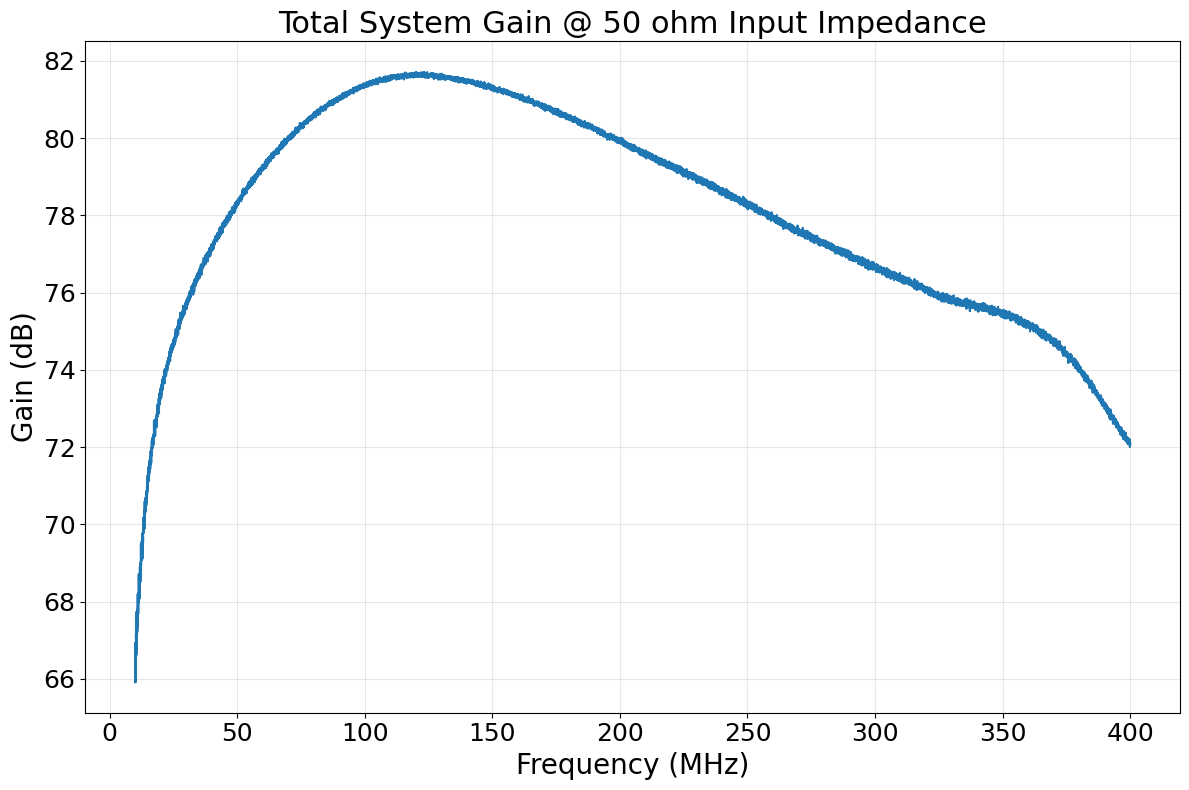

In [ ]:
lna_thermo.plot_gain(faxis, title='Total System Gain @ 50 ohm Input Impedance', save_path=pjoin(plot_path, 'system_gain_hot_cold.png'))

In [ ]:
# plot gain of LNA, WEA101
lna = pjoin(caltech_path, 'amp_s_params', 'LNA_5V.s2p')
second_stage = pjoin(caltech_path, 'amp_s_params', 'WEA101_5V.s2p')

s21s = S_Params([lna, second_stage], ['LNA', 'WEA101'])

lna_s21_db = s21s.get_s21()['LNA']
s21_f = s21s.ntwk_dict['LNA'].f/1e6

interpolated_gain, common_min, common_max = spec_proc.interpolate_arrs(s21_f, faxis, lna_thermo.g)

In [ ]:
# Load data measured
with open(pjoin(data_path, 'BB_ND.pkl'), 'rb') as f:
  BB_ND = pickle.load(f)

BB_Spec = Spectrum(faxis_hz, BB_ND['Black Body 014 - LNA']['spectrum'], name='Black Body 014')
ND_Spec = Spectrum(faxis_hz, BB_ND['Noise Diode 002 - LNA']['spectrum'], name='Noise Diode 002')

BB_ND_states = {'BB': BB_Spec, 'ND': ND_Spec}

In [ ]:
# Convert to proper units
BB_dbm = Spectrum.preprocess_states(load_states=BB_ND_states, remove_spikes=True, unit='dBm', offset=-128, system_gain=0)

In [ ]:
BB_kelvin = Spectrum(faxis_hz, unit_convert.dbm_to_kelvin(BB_dbm['BB'].s), name='Black body 014')
ND_kelvin = Spectrum(faxis_hz, unit_convert.dbm_to_kelvin(BB_dbm['ND'].s), name='Noise Diode 002')

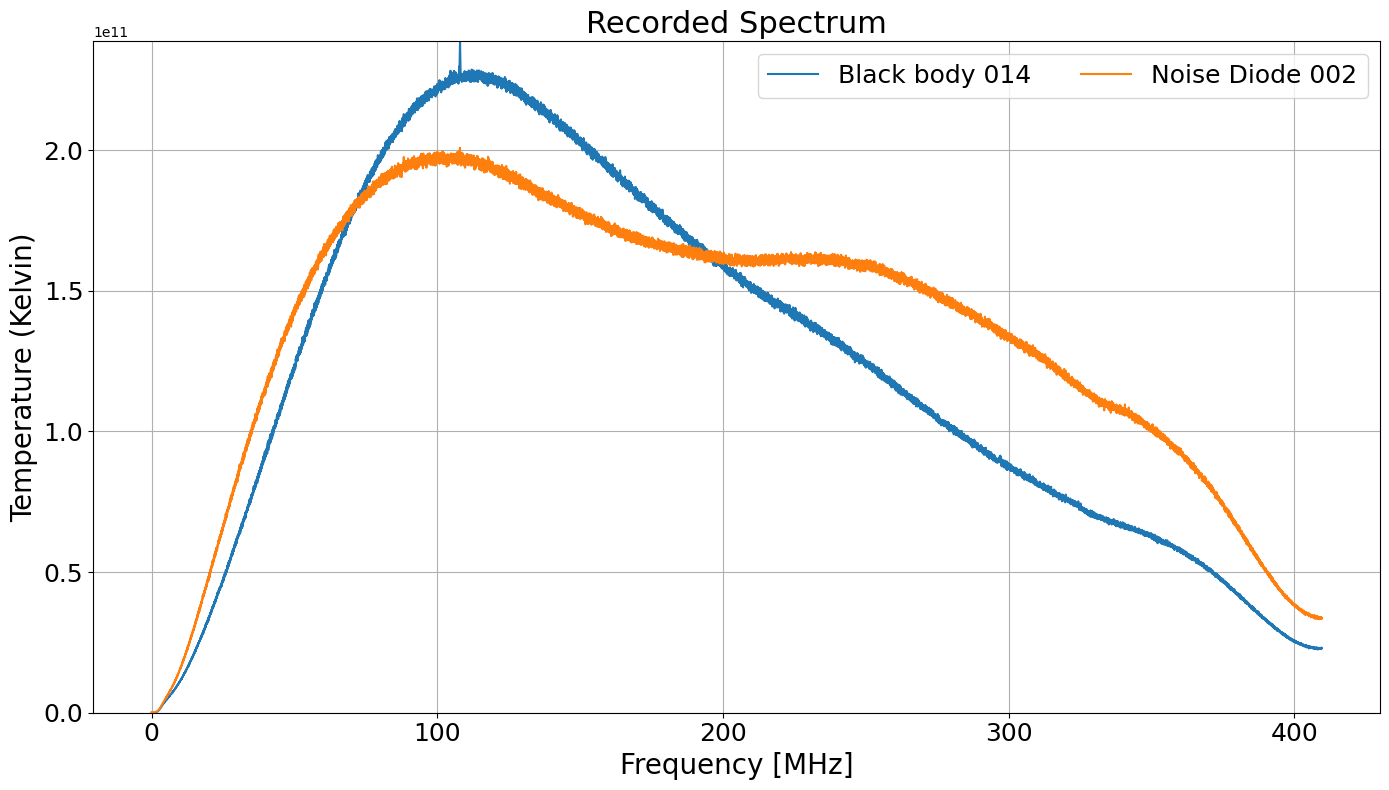

In [ ]:
plotter.plot_spectrum([BB_kelvin, ND_kelvin], ylabel='Temperature (Kelvin)')

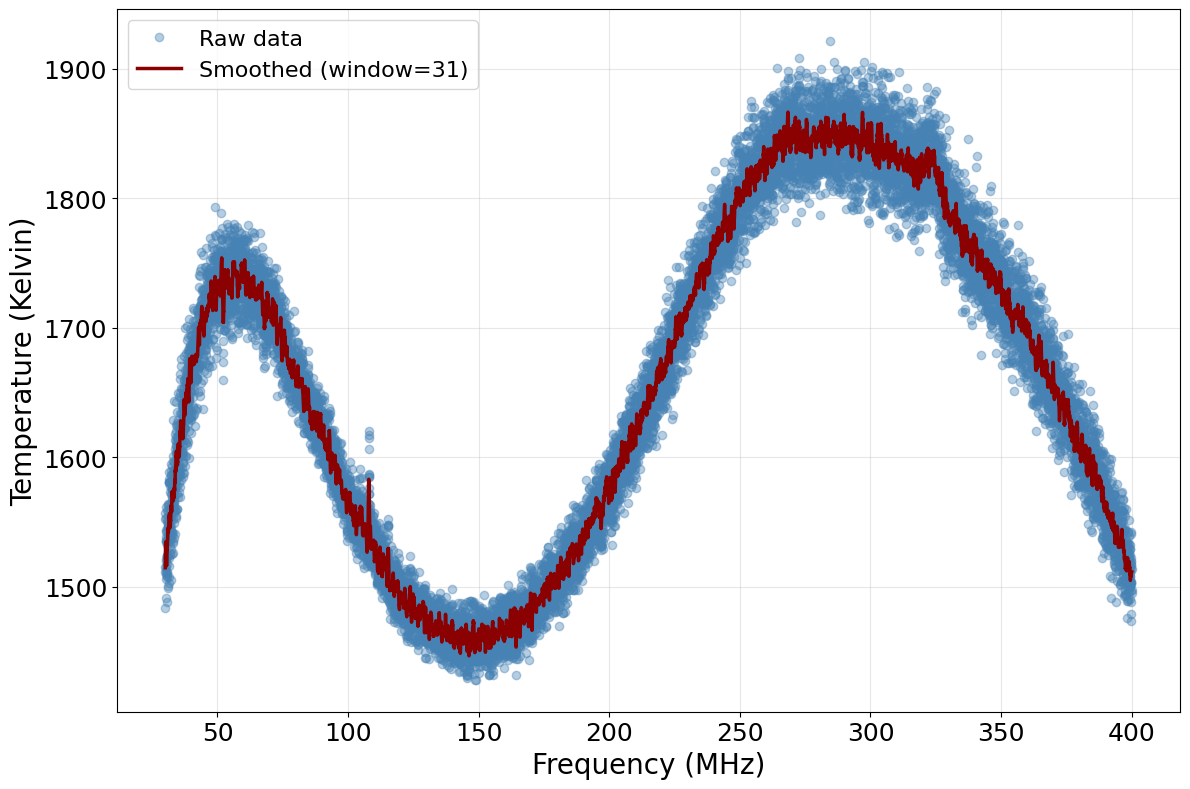

array([1514.63069451, 1519.79136865, 1524.07494459, ..., 1511.20759107,
       1511.37569826, 1511.48560495], shape=(14801,))

In [ ]:
lna_thermo.infer_temperature(faxis, unit_convert.dbm_to_milliwatt(BB_dbm['BB'].s), start_freq=30)

In [ ]:
loaded_kelvin_norm, gain = file_load.norm_states(f=faxis_hz, loaded_states=LNA_cal, ref_state_label='LNA-BB', ref_temp=1380, system_gain=0)
# spec_plot.plot_spectrum(loaded_kelvin_norm, save_dir=lna_path, suffix="temp_norm", ylabel='Noise Temperature [K]', freq_range=freq_range, ymin=50, ymax=2500, title='Calibrator temperatures with Blackbody as 1380K')

In [ ]:
y77_vals = LNA_mW['LNA-50ohm (77K)'].s[:,0,0]
y300_vals = LNA_mW['LNA-50ohm (300K)'].s[:,0,0]
y1380_vals = LNA_mW['LNA-BB'].s[:,0,0]
BB014_vals = BB_ND_mW['Black Body 014 - LNA'].s[:,0,0]
ND002_vals = BB_ND_mW['Noise Diode 002 - LNA'].s[:,0,0]

g_1, b_1 = fit_model.fit_lines(y77_vals, y300_vals, x1=77, x2=300)
g_2, b_2 = fit_model.fit_lines(y1380_vals, y300_vals, x1=1800, x2=300)
g_3, b_3 = fit_model.fit_lines(y1380_vals, y77_vals, x1=1800, x2=77)

f_values = LNA_mW['LNA-BB'].f/1e6

/usr/local/lib/python3.12/dist-packages/highz_exp/fit_model.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  y1 = np.asarray(y1, dtype=float)
/usr/local/lib/python3.12/dist-packages/highz_exp/fit_model.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  y2 = np.asarray(y2, dtype=float)


/tmp/ipython-input-644763566.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  y_arr = np.asarray(y_values, dtype=float)


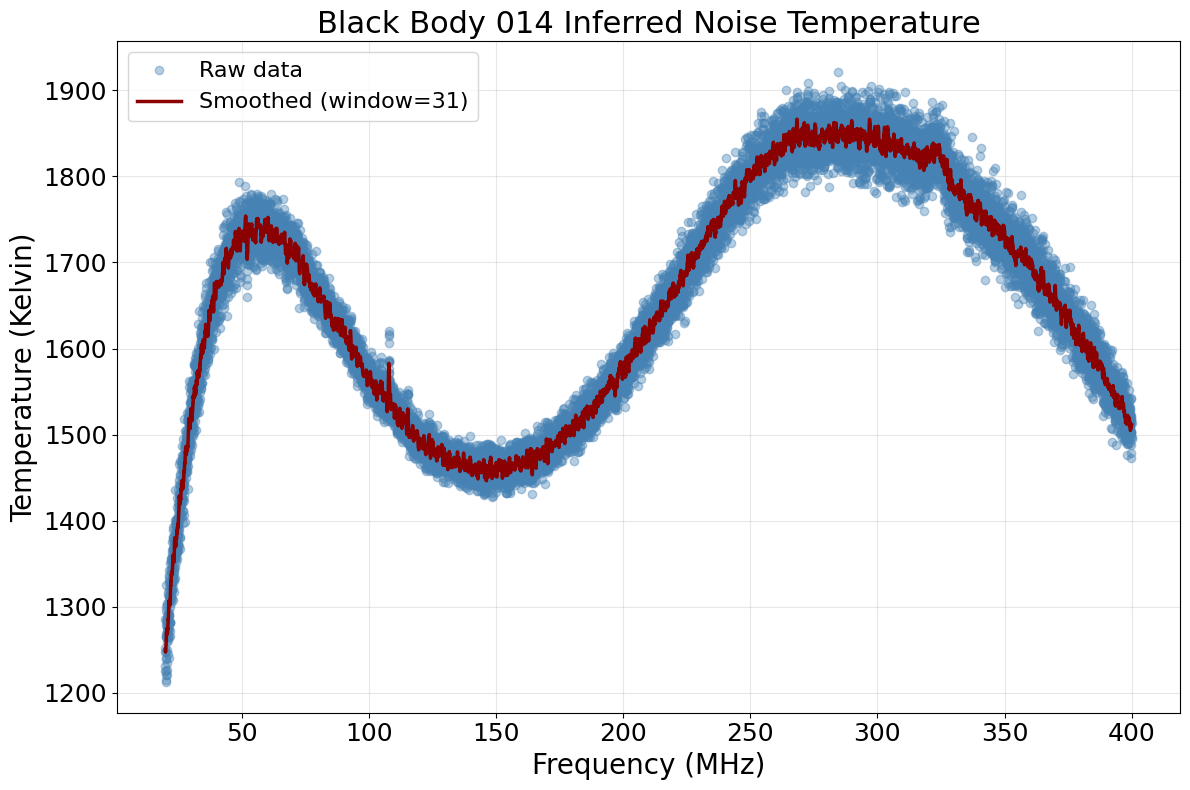

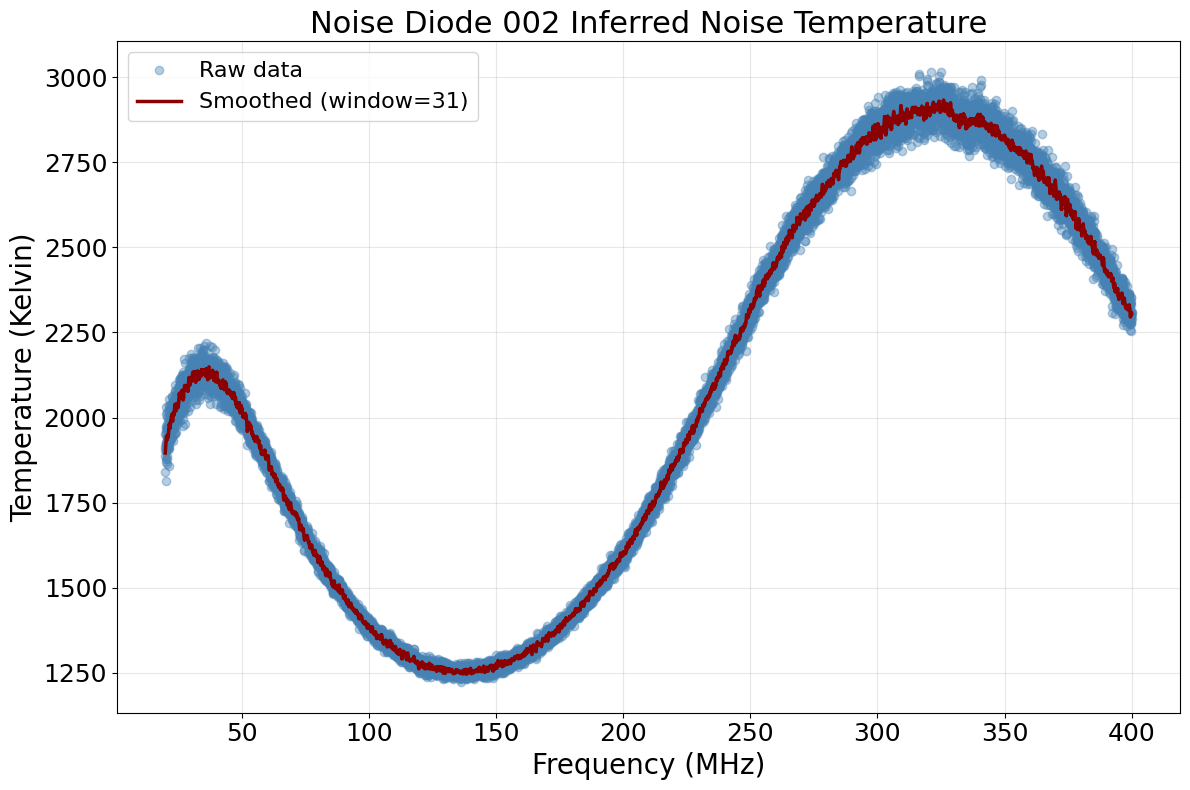

array([1895.65627984, 1898.09918609, 1900.49518003, ..., 2308.08623951,
       2307.15086881, 2305.74354183], shape=(15201,))

In [ ]:
# using 77-300K gradient and intercept, extrapolate black body noise temperature
infer_temperature(f_values, g_1, b_1, BB014_vals, start_freq=20, title='Black Body 014 Inferred Noise Temperature', save_path=pjoin(lna_path, 'BB014_temp.png'))
infer_temperature(f_values, g_1, b_1, ND002_vals, start_freq=20, title='Noise Diode 002 Inferred Noise Temperature', save_path=pjoin(lna_path, 'ND002_temp.png'))

/tmp/ipython-input-644763566.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  y_arr = np.asarray(y_values, dtype=float)


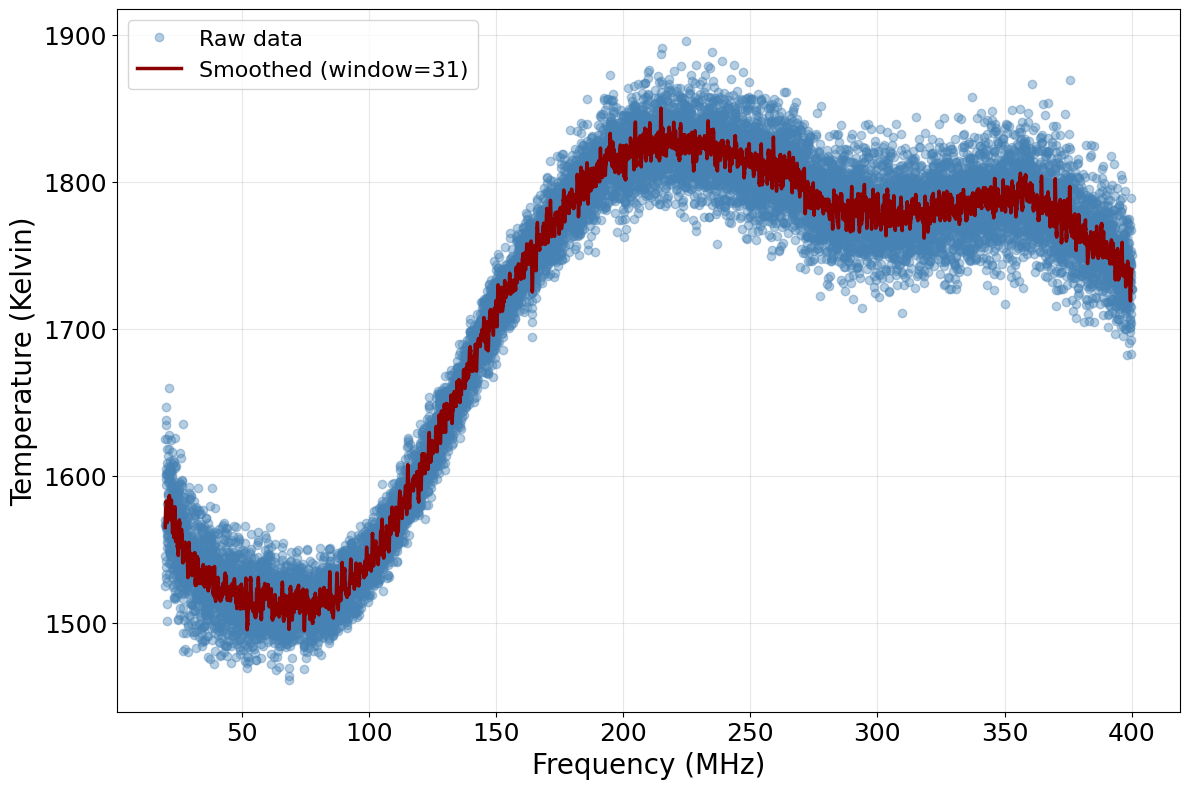

array([1564.77974001, 1567.60623439, 1569.99764829, ..., 1739.79188925,
       1740.14595233, 1740.25088561], shape=(15201,))

In [ ]:
# using 77-300K gradient and intercept, extrapolate black body noise temperature
infer_temperature(f_values, g_1, b_1, y1380_vals, start_freq=20)

/tmp/ipython-input-2088747978.py:10: RuntimeWarning: invalid value encountered in log10
  g_dbm = np.log10(g/(25*1000*k_B)) * 10


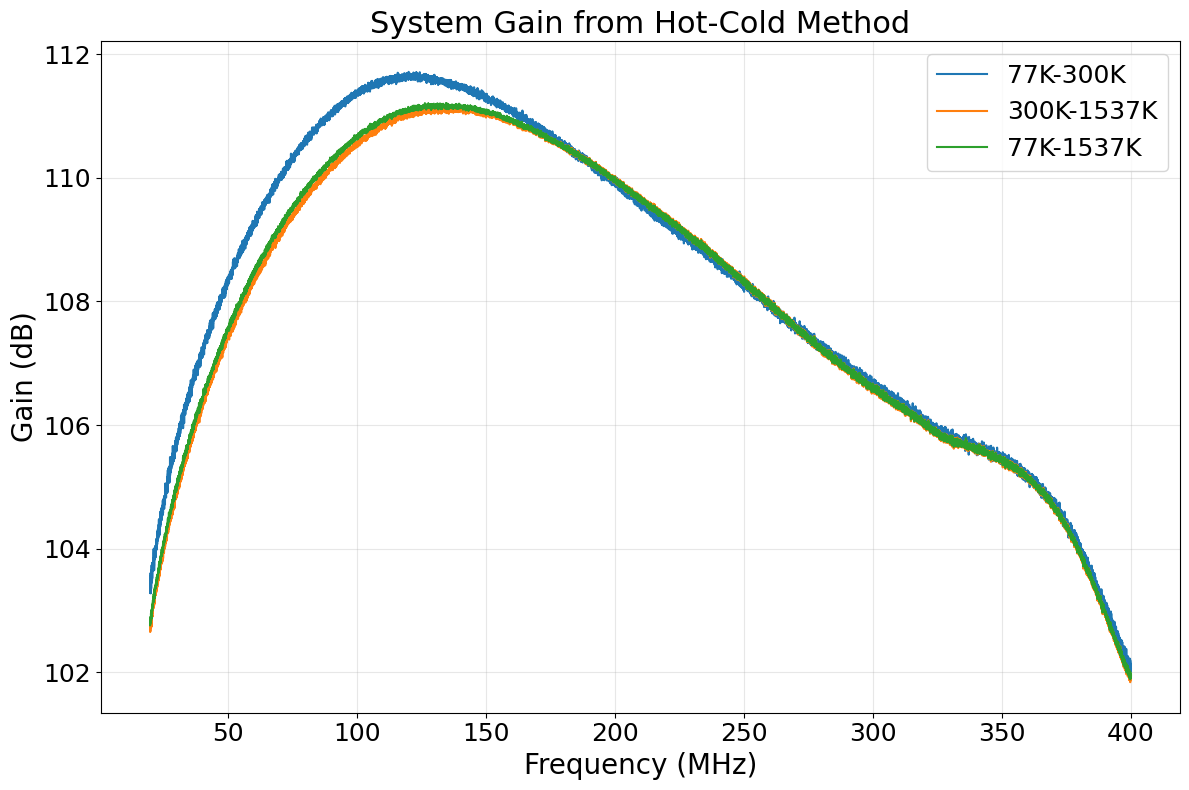

In [ ]:
plot_gain(f_values, [g_1, g_2, g_3], labels=['77K-300K', '300K-1537K', '77K-1537K'], start_freq=20, xlabel='Frequency (MHz)', title='System Gain from Hot-Cold Method',
         save_path=None)

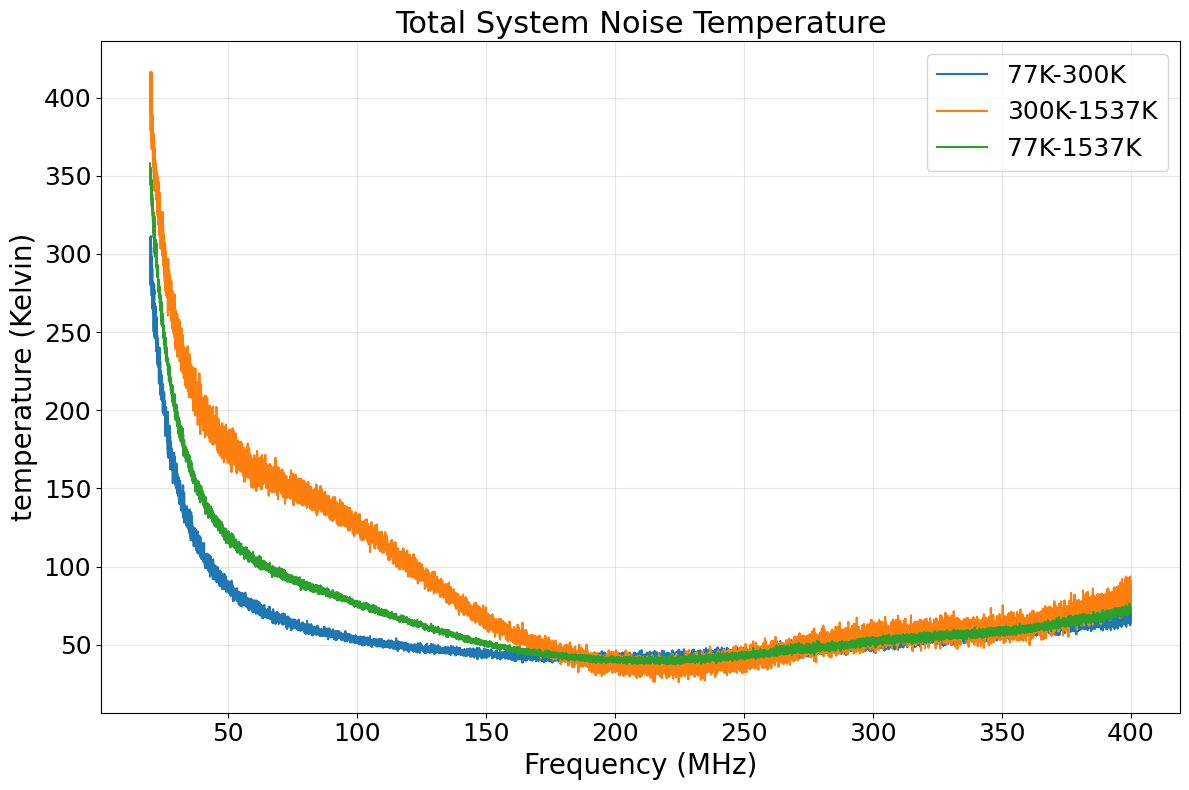

In [ ]:
plot_fitted_lines(f_values,[g_1, g_2, g_3],[b_1, b_2, b_3],
    labels=['77K-300K', '300K-1537K', '77K-1537K'],
    start_freq=20,
    xlabel='Frequency (MHz)',
    title='Total System Noise Temperature',
    save_path=None
)

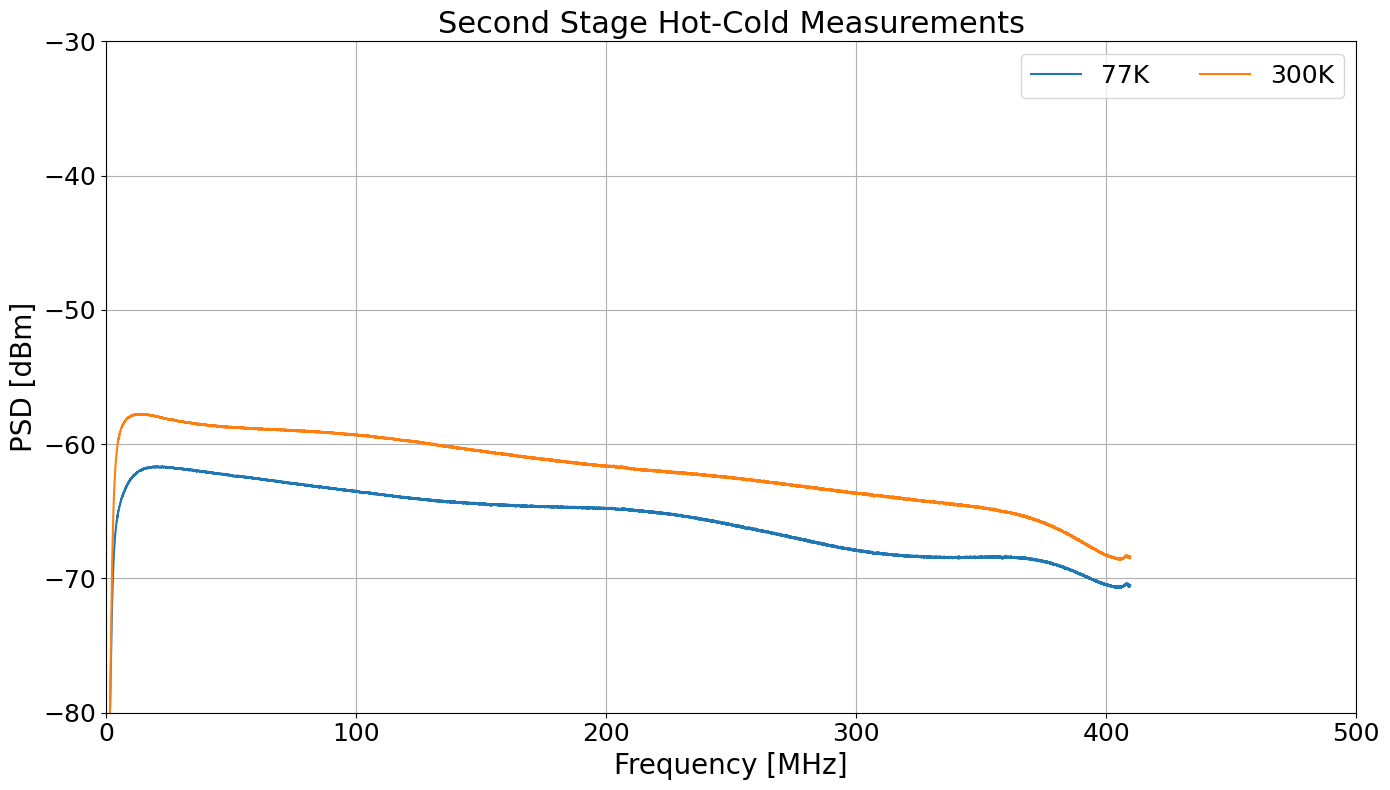

In [ ]:
# convert measured noise power to right units
noise_dbm = file_load.preprocess_states(faxis=faxis_hz, load_states=second_stage, remove_spikes=True, unit='dBm', offset=-128, system_gain=0)
spec_plot.plot_spectrum(noise_dbm, save_dir=plot_path, suffix="second_stage", freq_range=freq_range, ymin=-80, ymax=-30, title='Second Stage Hot-Cold Measurements')
noise_mW = spec_proc.apply_to_all_ntwks(unit_convert.dbm_to_milliwatt, noise_dbm)

/tmp/ipython-input-379143035.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=18)


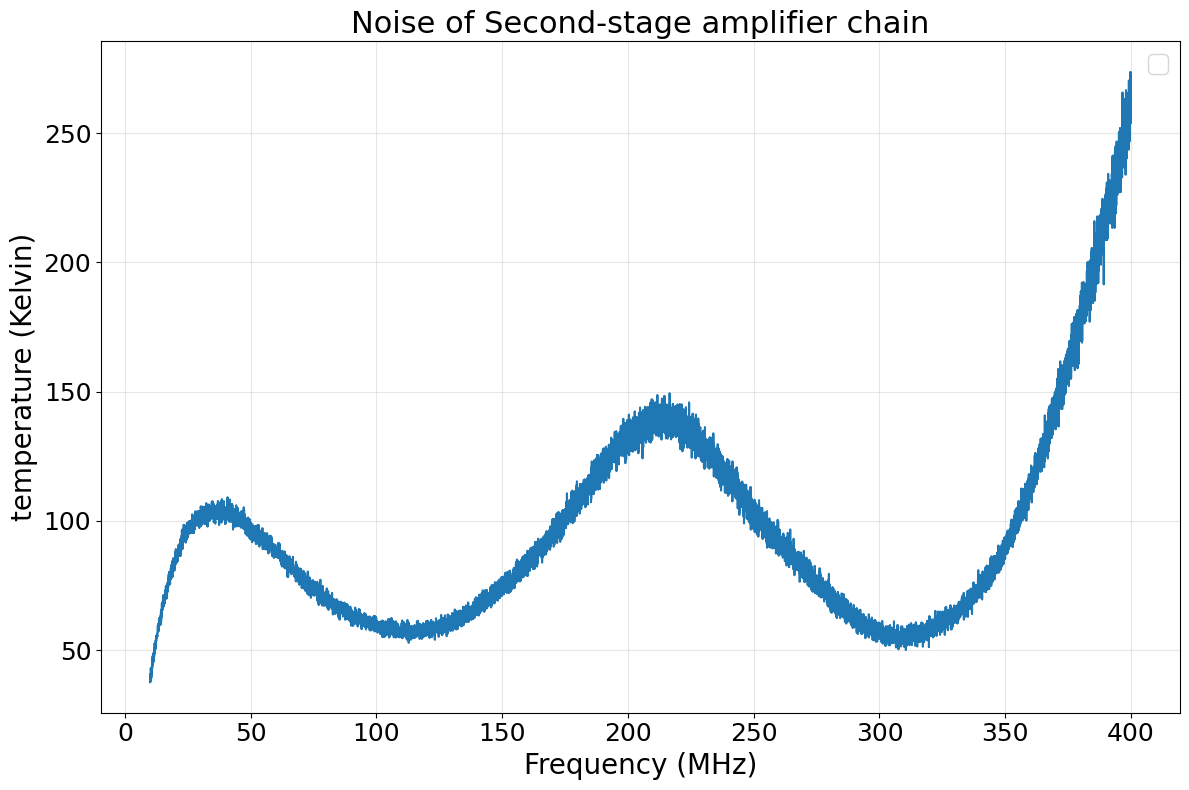

In [ ]:
y77_vals = noise_mW['77K'].s[:,0,0]
y300_vals = noise_mW['300K'].s[:,0,0]

g, b = fit_model.fit_lines(y77_vals, y300_vals, x1=77, x2=300)

f_values = noise_mW['77K'].f/1e6

plot_fitted_lines(
    f_values,
    [g],
    [b],
    [None],
    start_freq=10,
    end_freq=400,
    xlabel='Frequency (MHz)',
    title='Noise of Second-stage amplifier chain', save_path=pjoin(plot_path, 'second_stage_temp.png')
)

/tmp/ipython-input-1334404674.py:10: RuntimeWarning: invalid value encountered in log10
  g_dbm = np.log10(g/(25*1000*k_B)) * 10
/tmp/ipython-input-1334404674.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=18)


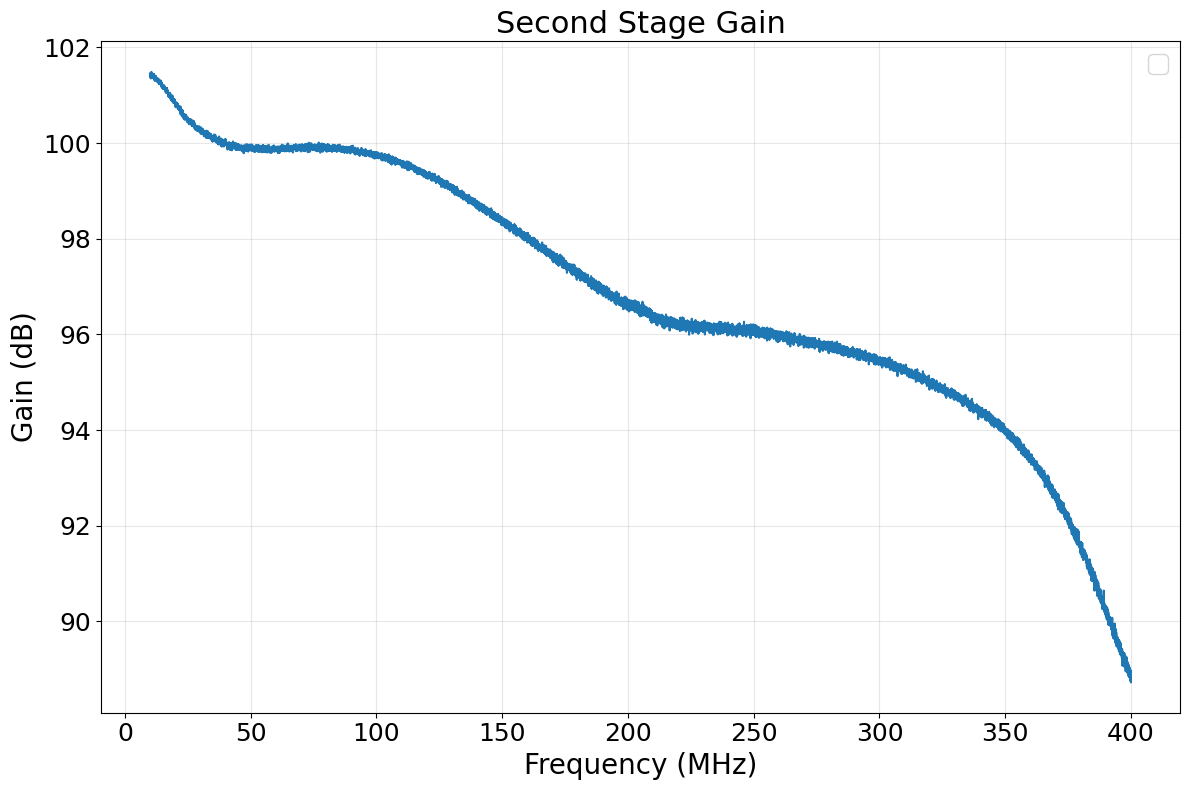

In [ ]:
plot_gain(f_values, [g], labels=[None], start_freq=10, xlabel='Frequency (MHz)', title='Second Stage Gain', save_path=pjoin(plot_path, 'second_stage_gain.png'))